### In this notebook, I try to add stellar mass into $\vec{\theta}$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [3]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)
speculator.network.eval();

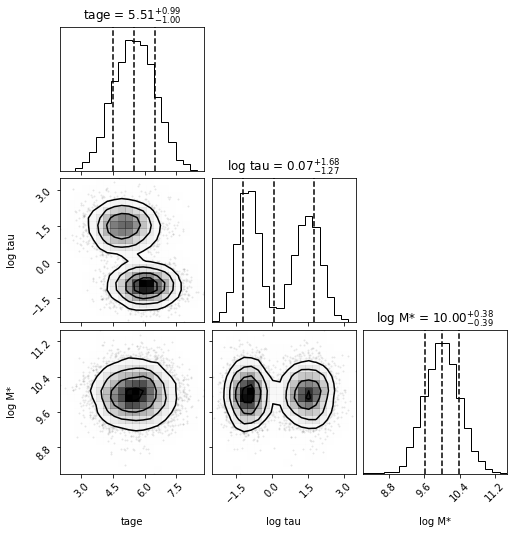

In [4]:
# y_test = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=3000)
y_test1 = np.random.multivariate_normal(mean=[6, -1], cov=[[0.7, 0.], [0., 0.2]], size=2500)
y_test2 = np.random.multivariate_normal(mean=[5, 1.5], cov=[[0.7, 0.], [0., 0.3]], size=2500)
#y_test2 = np.random.multivariate_normal(mean=[6, 0], cov=[[-0.7, 0.3], [0.3, -0.1]], size=1500)
y_test = np.vstack([y_test1, y_test2])
y_stellar_mass = torch.normal(10, 0.4, size=(len(y_test), 1)).to('cuda')
#torch.ones(size=(len(y_test), 1)).to('cuda') * 10.0 
y_test = Tensor(y_test).to('cuda')
x_test = speculator.predict_mag(y_test, 
                                stellar_mass=10**y_stellar_mass, 
                                redshift=None,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz']
                               ).cpu().detach().numpy()
x_test = Tensor(x_test).to('cuda')

figure = corner.corner(np.hstack([y_test.cpu().detach().numpy(), y_stellar_mass.cpu().detach().numpy()]), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log M*'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [5]:
# from popsed.nde import diff_KL_w2009_eq29
from popsed.speculator import StandardScaler
from popsed.nde import NeuralDensityEstimator
from geomloss import SamplesLoss

In [193]:
# NDE = NeuralDensityEstimator(method='nsf')
# NDE.build(x_test, optimizer='adam')
# NDE.train(n_epochs=4000, display=True)
# with open('./best_loss_model_nde_nsf.pkl', 'rb') as f:
#     NDE = pickle.load(f)
# samples = NDE.sample(2000)

### We try to achieve our goal with loss = Sinkhorn(X, Y), where X is the observed SED, and Y is the model output.

In [6]:
NDE_theta = NeuralDensityEstimator(method='nsf', num_transforms=5, num_bins=15, hidden_features=70)
NDE_theta.build(torch.hstack([y_test, y_stellar_mass]), optimizer='adam', lr=8e-4)
NDE_theta.min_loss = 0.02
NDE_theta.best_loss_epoch = 0

scaler = StandardScaler(device='cuda')
scaler.fit(x_test)

In [7]:
patience = 5
N_samples = 5000

In [8]:
X = scaler.transform(x_test)

# Define a Sinkhorn (~Wasserstein) loss between sampled measures
L = SamplesLoss(loss="sinkhorn", p=1, blur=.01, scaling=0.8)
for epoch in trange(100, desc='Training NDE_theta', unit='epochs'):
    NDE_theta.optimizer.zero_grad()
    Y = scaler.transform(speculator._predict_mag_with_mass(NDE_theta.sample(N_samples)))
    loss = L(X, Y)
    loss.backward()
    NDE_theta.optimizer.step()
    NDE_theta.train_loss_history.append(loss.item())
    
NDE_theta.optimizer.param_groups[0]['lr'] = 5e-4
L = SamplesLoss(loss="sinkhorn", p=1, blur=.01, scaling=0.8)
for epoch in trange(100, desc='Training NDE_theta', unit='epochs'):
    NDE_theta.optimizer.zero_grad()
    Y = scaler.transform(speculator._predict_mag_with_mass(NDE_theta.sample(N_samples)))
    loss = L(X, Y)
    if loss.item() < NDE_theta.min_loss:
        NDE_theta.min_loss = loss.item()
        if epoch - NDE_theta.best_loss_epoch > patience:
            # Don't save model too frequently
            NDE_theta.best_loss_epoch = epoch
            NDE_theta.save_model(
                f'nde_theta_best_loss_nsf.pkl')
    loss.backward()
    NDE_theta.optimizer.step()
    NDE_theta.train_loss_history.append(loss.item())
    
NDE_theta.optimizer.param_groups[0]['lr'] = 3e-4
L = SamplesLoss(loss="sinkhorn", p=1, blur=.01, scaling=0.8)
for epoch in trange(100, desc='Training NDE_theta', unit='epochs'):
    NDE_theta.optimizer.zero_grad()
    Y = scaler.transform(speculator._predict_mag_with_mass(NDE_theta.sample(N_samples)))
    loss = L(X, Y)
    if loss.item() < NDE_theta.min_loss:
        NDE_theta.min_loss = loss.item()
        if epoch - NDE_theta.best_loss_epoch > patience:
            # Don't save model too frequently
            NDE_theta.best_loss_epoch = epoch
            NDE_theta.save_model(
                f'nde_theta_best_loss_nsf.pkl')
    loss.backward()
    NDE_theta.optimizer.step()
    NDE_theta.train_loss_history.append(loss.item())

Training NDE_theta: 100%|███████████████████████████| 100/100 [00:46<00:00,  2.14epochs/s]


(0.01611965189827864, 0.1)

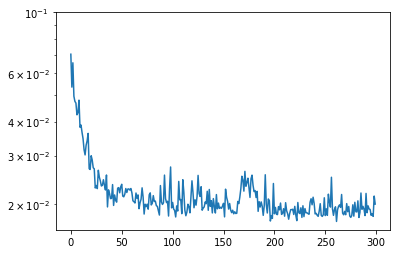

In [10]:
plt.plot(NDE_theta.train_loss_history)
plt.yscale('log')
plt.ylim(-0.01, 0.1)

In [11]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch])

Best epoch: 96
Best loss: 0.01809532567858696


In [23]:
with open('./nde_theta_best_loss_nsf.pkl', 'rb') as f:
    NDE_theta = pickle.load(f)

In [12]:
samples = NDE_theta.sample(5000)
# samples_logp = NDE_theta.net.log_prob(samples).detach()
# speculator._predict_mag_with_mass(samples)

# import torch.nn.functional as F
# out = F.kl_div(samples_logp, samples_logp)

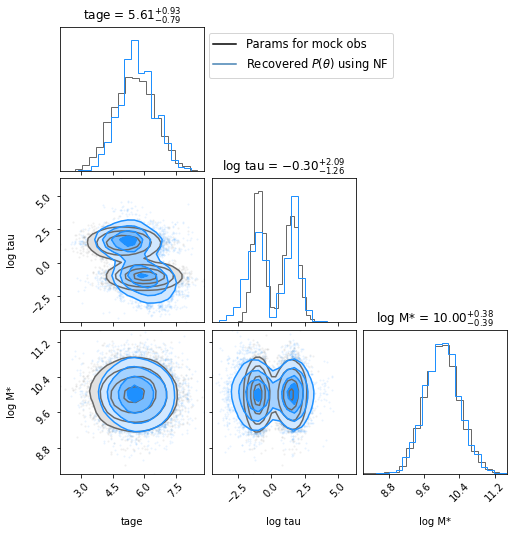

In [13]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log M*']

figure = corner.corner(np.hstack([y_test.cpu().detach().numpy(), y_stellar_mass.cpu().detach().numpy()]), 
                       color='dimgray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(NDE_theta.sample(10000).cpu().detach().numpy(), 
                  fig=figure, labels=labels, #range=[[3, 9], [-2, 2]],
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

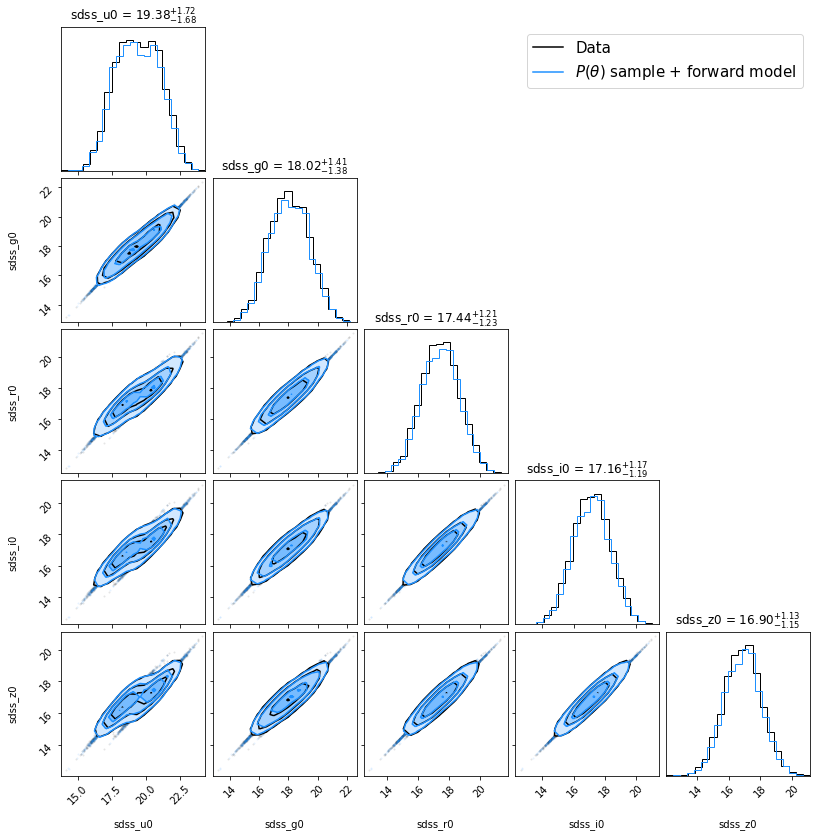

In [201]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(x_test.cpu().detach().numpy(), 
                       color='k', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.7, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

# nf_plot = corner.corner(samples.cpu().detach().numpy(), 
#                   fig=figure, labels=labels,
#                   color='tomato', #quantiles=[0.16, 0.5, 0.84], 
#                   smooth=0.5, fill_contours=True,
#                   show_titles=False, title_kwargs={"fontsize": 12})

nf_plot = corner.corner(speculator._predict_mag_with_mass(samples).cpu().detach().numpy(), 
                  fig=figure, labels=labels,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.7, fill_contours=True,
                  show_titles=False, title_kwargs={"fontsize": 12})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

https://zhuanlan.zhihu.com/p/33752313
   
https://dfdazac.github.io/sinkhorn.html

https://zhuanlan.zhihu.com/p/25071913